In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhanceS
import albumentations as A
from tqdm.notebook import tqdm

In [2]:
labels = pd.read_csv('../input/global-wheat-detection/train.csv')
labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [3]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

labels = labels.groupby('image_id').apply(group_boxes)

In [5]:
train_image_ids = np.unique(labels.index.values)[0:3363]
val_image_ids = np.unique(labels.index.values)[3363:3373]

With the ids split it's now time to load the images. To keep the training of the model relatively fast I will resize each image from (1024,1024) to (256,256). I experimented with larger images and with the model I am using I didn't see a good enough lift in training accuracy to make up for the extra time it took to train a model for larger images.

In [6]:
def load_image(image_id):
    image = Image.open('../input/global-wheat-detection/train/' + image_id + ".jpg")
    image = image.resize((256, 256))
    
    return np.asarray(image)

In [7]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy() / 4

In [8]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = labels[image_id].copy() / 4

## Visualise images

Before going on it is worth having a look at some of the images and bounding boxes in the dataset. For that a few helper functions will be required. The below functions take an image id and the corresponding bounding boxes and return the bounding boxes drawn onto the image.

In [9]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open('../input/global-wheat-detection/' + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

In [10]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

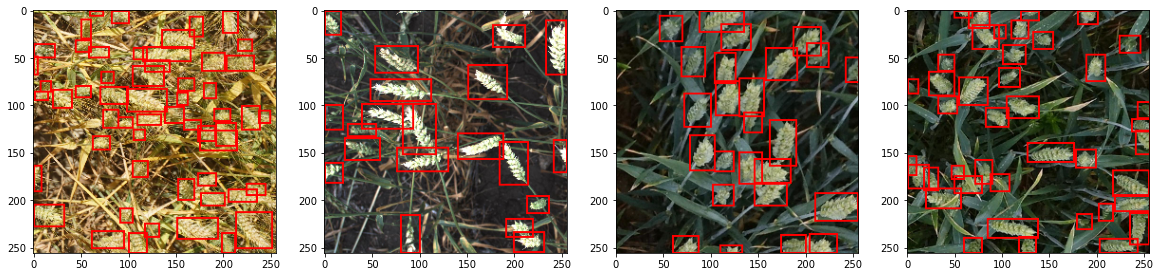

In [11]:
show_images(train_image_ids[0:4], train_labels)

## Clean bounding boxes

There are a small number of bounding boxes in this dataset that do not bound a head of wheat. While the number is small enough that the model can still learn how to detect the heads of wheat they still cause a little bit of inaccuracy. Below I'll search for tiny bounding boxes that cannot possibly fit a head of wheat inside them and huge bounding boxes that miss the head of wheat they are aimed at.

In [12]:
tiny_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] <= 10 and label[2] * label[3] != 0:
            tiny_bboxes.append(i)

            
print(str(len(tiny_bboxes)) + ' tiny bounding boxes found')

50 tiny bounding boxes found


In [13]:
huge_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] > 8000:
            huge_bboxes.append(i)

            
print(str(len(huge_bboxes)) + ' huge bounding boxes found')

13 huge bounding boxes found


The tiny bounding boxes are actually too small to show when visualised on an image. However we can take a peak at one of the huge bounding boxes.

In [15]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

train_labels = clean_labels(train_image_ids, train_labels)

## Data pipeline

- define the size of the dataset. Keras needs this to work out how long an epoch is.
- shuffle the dataset.
- get an image and augment it to add variety to the dataset. This includes amending bounding boxes when a head of wheat has changed in the image.
- reshape the bounding boxes to a label grid.

I'll start by initialising the class.

In [16]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((16, 16, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 16, 256 / 16] 

        for i in range(0, 16):
            for j in range(0, 16):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

In [17]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

Regarding the augmentations a number of transformations will be applied to each training image before they are fed into the model. This helps to add some diversity to a small dataset effectively growing it to a much larger one:

- **random sized crop:** The model needs to be able to detect a wheat head regardless of how close or far away the head is to the camera. To produce more zoom levels in the dataset the crop method will take a portion of the image and zoom in to create a new image with larger wheat heads.
- **flip amd rotate**: The wheat heads can point in any direction. To create more examples of wheat heads pointing in different directions the image will randomly be flipped both horizontally and vertically or rotated.
- **hue saturation and brightness:** these are various methods that will alter the lighting of the image which will help to create different lighting scenarios. This helps as the test pictures are from various countries each with their own lighting levels.
- **noise:** Some wheat heads aren't quite in focus. Adding some noise to the images helps to catch these wheat heads while also forcing the model to learn more abstract wheat head shapes. This helps a lot with over-fitting.
- **cutout**: randomly remove small squares of pixels in the image. This prevents the model simply memorizing certain wheat heads and instead forces it to learn the patterns that represent a wheat head.
- **clahe:** this is a must have. In many images the wheat heads are a similar colour to the grass in the background making it tricky for the model to differentiate between them. CLAHE helps to exemplify the colour difference between the two.
- **grey scale:** I found that there were a few images with a yellow/gold tint. My model was learning to detect wheat heads without a tint (as most images do not contain a tint) and was really struggling to detect anything on the yellow images. By converting all images to grey scale the model is forced to ignore these tints making it much more effective at identifying wheat heads regardless of tint.

I also greyscale and apply CLAHE to each validation image as the model has learnt on grey images where the wheat heads are given a lighter shade of grey.

In [18]:
DataGenerator.train_augmentations = A.Compose([
        A.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        A.OneOf([
            A.Flip(),
            A.RandomRotate90(),
        ], p=1),
        A.OneOf([
            A.HueSaturationValue(),
            A.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            A.GaussNoise(),
            A.GlassBlur(),
            A.ISONoise(),
            A.MultiplicativeNoise(),
        ], p=0.5),
        A.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        A.CLAHE(p=1),
        A.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    A.CLAHE(p=1),
    A.ToGray(p=1),
])

The next finctions load an image and the corresponding bounding boxes depending on randomly picked image ids. As well as loading the images the above augmentations are added to an image as it is loaded. As the albumentaitons library was used the apply these augmentations I get the bounding boxes re-sized for free.

In [19]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [20]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((16, 16, 10))

    for i in range(0, 16):
        for j in range(0, 16):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            if anchor_one[0] != 0 and anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            if anchor_one[0] != 0 and anchor_two[0] != 0:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [21]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=8, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [1]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.MaxPooling2D((1, 1), strides=(1, 1))(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

KeyboardInterrupt: 

One issue with yolo is that it is likely to contain more cells in its label grid that contain no objects than cells that do contain objects. It is easy then for the model to focus too much on learning to reduce no object cells to zero and not focus enough on getting the bounding boxes to the right shape. To overcome this the yolo [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) suggests weighting the cells containing bounding boxes five times higher and the cells with no bounding boxes by half. 

I have defined a custom loss function to do just this. I have also split the loss function into three parts. The first takes care of the confidence score that is trying to work out if a label grid cell contains a head of wheat or not. Binary cross entropy is used here as that is a binary classification task. The second part looks at the x,y position of the bounding boxes while the third looks at the width,height of the bounding boxes. MSE (mean squared loss) is used for the second and third parts as they are regression tasks. 

In [23]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [24]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

 I considered using learning rate decay to handle this but decided on a callback to reduce the learning rate when it plateaus (or increases) over the space of two epochs. This allows the model to make the most of a higher rate until it that rate is too high at which point the model wuicky reduces it.

In addition to this I have added an early stopping callback to stop the model training if is no longer able to reduce the loss. This reduces any waste processing and provides faster feedback if the model just isn't training very well.

In [25]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

Finally the model is ready to be trained. The data generators are passed into the fit generator method of the model alongside the callbacks and the maximum number of epochs to take. Be warned that with 100 or less images this model can train at an okay speed on CPU. Any more images than that will need the GPU (which could still run for a few hours).

In [26]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=120,
    callbacks=callbacks
)

Train for 420 steps, validate for 1 steps
Epoch 1/120
420/420 [==============================] - 208s 495ms/step - loss: 0.5177 - val_loss: 0.4663
Epoch 2/120
420/420 [==============================] - 193s 458ms/step - loss: 0.3627 - val_loss: 0.4362
Epoch 3/120
420/420 [==============================] - 192s 458ms/step - loss: 0.3407 - val_loss: 0.3736
Epoch 4/120
420/420 [==============================] - 193s 459ms/step - loss: 0.3109 - val_loss: 0.3471
Epoch 5/120
420/420 [==============================] - 193s 460ms/step - loss: 0.2945 - val_loss: 0.3253
Epoch 6/120
420/420 [==============================] - 192s 458ms/step - loss: 0.2816 - val_loss: 0.3343
Epoch 7/120
420/420 [==============================] - 192s 457ms/step - loss: 0.2719 - val_loss: 0.2837
Epoch 8/120
420/420 [==============================] - 192s 456ms/step - loss: 0.2647 - val_loss: 0.2807
Epoch 9/120
420/420 [==============================] - 191s 455ms/step - loss: 0.2594 - val_loss: 0.3213
Epoch 10/120


## Prediction post processing

The model outputs the predicted bounding boxes as a label grid. However to visualise the bounding boxes on an image or submit them to the competition the shape for one images bounding boxes need changing from (16,16,10) to (m, 4) where m represents the number of bounding boxes that have a high confidence.

This first function transforms the boxes from the yolo format to the coco format. It does this through the following:

- return the scale of the boxes from 0-1 to 0-256
- change the x,y from the centre of the box to the top left corner
- change width and height to x_max, y_max i.e. change to voc shape

In [27]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 16)
    im_height = (image_grid[:,:,3] * 16)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

Next the bounding boxes with low confidence need removing. I also need to remove any boxes that overlap another box. Luckily Tensorflow has a non-max suppression function that filters out both low confidence boxes and removes one box if any two overlap.

In [28]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((16*16, 4))
    second_anchors = predictions[:,:,6:10].reshape((16*16, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

Wrap these post-processing functions into one and output the predicted bounding boxes as a dictionary where the image id is the key.

In [29]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

Let's see how the model did by producing predictions for the training and validation datasets and show these boxes on the first four images from each set.

In [30]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=1, 
    shuffle=False,
    augment=False
)

train_predictions = model.predict(train_generator)
train_predictions = process_predictions(train_predictions, train_image_ids, image_grid)

In [31]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

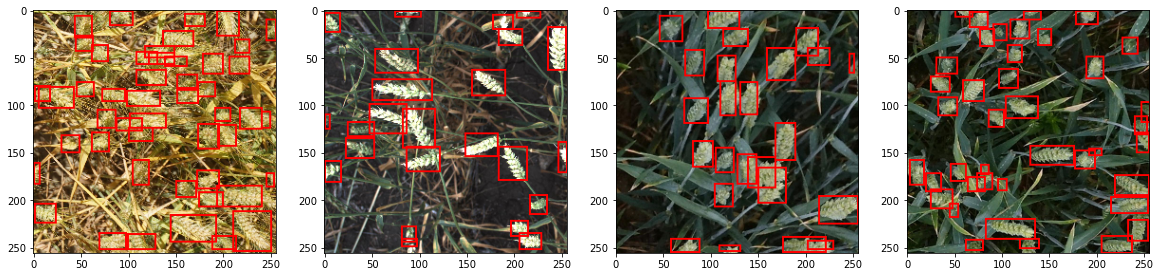

In [32]:
show_images(train_image_ids[0:4], train_predictions)

## Evaluate Model

With the model trained it's time to look at the quality of the model. Begin by plotting the loss curve.

In [34]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

Epochs: 50
Final training loss: 0.19957756765541576
Final validation loss: 0.200545072555542


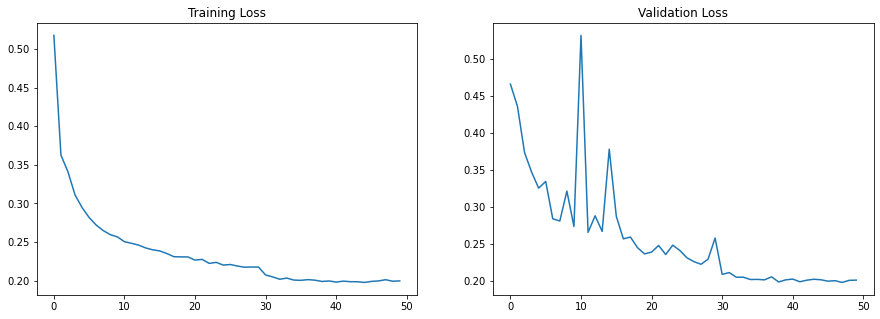

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

Then visualise the first few layers of the model to see how each layer influences the bounding boxes. Start by copying the model and configuring the new one to return each layers output when a prediction is made.

In [36]:
layer_outputs = [layer.output for layer in model.layers]
evaluation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

Then pick an image and cycle through the layers making a prediction and visualising the features outputted by the layer. The warm colours represent where the features lie in this image.

In [37]:
image = Image.open('../input/global-wheat-detection/train/' + train_image_ids[1] + ".jpg")
image = image.resize((256, 256))

pixels = np.asarray(image) / 255
pixels = np.expand_dims(pixels, axis=0)

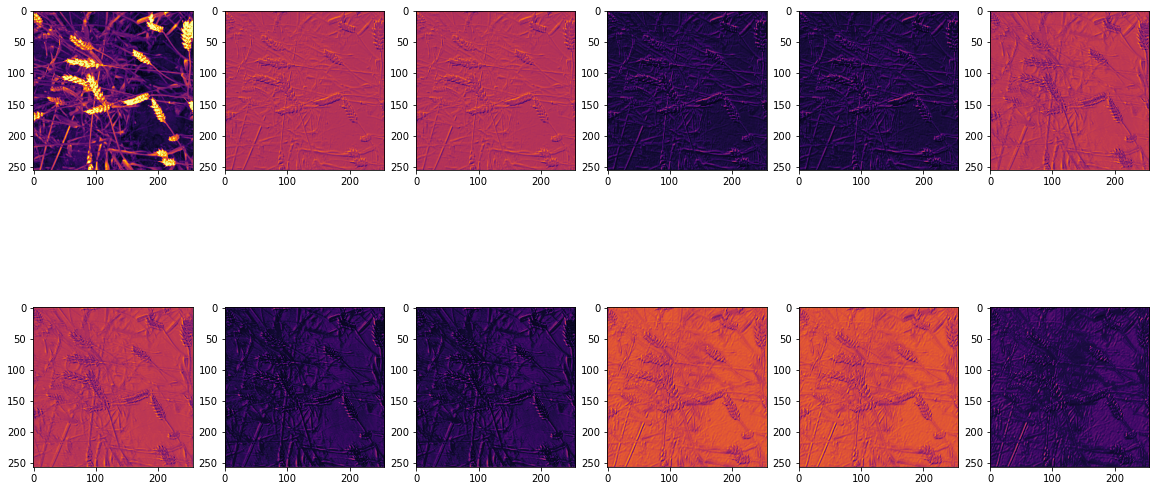

In [38]:
num_of_layers = len(layer_outputs)

fig, axes = plt.subplots(2, 6, figsize=(20, 10))

layer = 0
for i in range(0, 2):
    for j in range(0, 6):
        layer_output = evaluation_model.predict(pixels)[layer]
        axes[i, j].imshow(layer_output[0, :, :, 1], cmap='inferno')
        
        layer = layer + 1

## Test Images

Finally predict bounding boxes for the test set. I wanted to see how easy/difficult it would be to use the model without a data generator class so I have inputted the images into the model as numpy arrays.

First, load the test image ids.

In [39]:
test_image_ids = os.listdir('/kaggle/input/global-wheat-detection/test/')
test_image_ids = [image_id[:-4] for image_id in test_image_ids]

Now loop through the images, loading each one as a numpy array, applying augmentations to it and feeding it into the model. Save the bounding box predictions as a numpy array.

In [40]:
test_predictions = []

for i, image_id in enumerate(test_image_ids):
    image = Image.open('/kaggle/input/global-wheat-detection/test/' + image_id + ".jpg")
    image = image.resize((256, 256))            

    pixels = np.asarray(image)

    val_augmentations = albu.Compose([
        albu.CLAHE(p=1),
        albu.ToGray(p=1)
    ])

    aug_result = val_augmentations(image=pixels)
    pixels = np.array(aug_result['image']) / 255
    
    pixels = np.expand_dims(pixels, axis=0)
    
    bboxes = model.predict(pixels)

    test_predictions.append(bboxes)
    
test_predictions = np.concatenate(test_predictions)

Then apply the typical post processing functions to the predictions.

In [41]:
test_predictions = process_predictions(test_predictions, test_image_ids, image_grid)

Although only a submission to the competition will provide a final score on how good the model is, I'll visualise each test image with their predicted boxes to get an idea of the models quality. This involves a slightly different visualisation function just to accomodate the larger images.

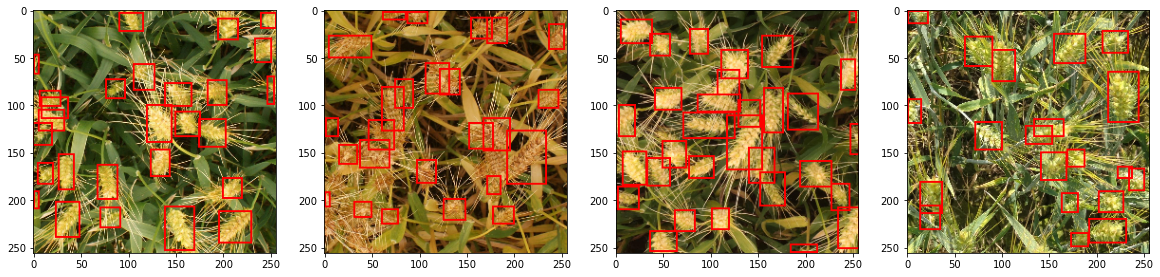

In [42]:
show_images(test_image_ids[0:4], test_predictions, source='test')

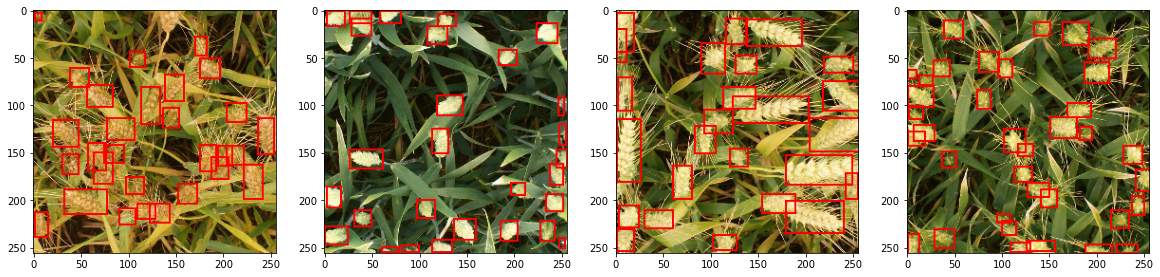

In [43]:
show_images(test_image_ids[4:8], test_predictions, source='test')

In [45]:
model.save_weights('wheat_detection_model.h5')